<a href="https://colab.research.google.com/github/starkworld/Future-Sales-Prediction/blob/master/Future_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler


from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Dataset

In [2]:
item_cat = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/items.csv')
train = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
items = items.drop(['item_name'], axis=1)

In [3]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

## Printing range of columns of datasets

In [4]:
print('Train')
for i in train.columns.values:
  print(f"{i}, {train[i].min()}, {train[i].max()}")

print('Items')
for j in items.columns.values:
  print(f'{j}, {items[j].min()}, {items[j].max()}')

print('Test')
for t in test.columns.values:
  print(f"{t}, {test[t].min()}, {test[t].max()}")

Train
date, 01.01.2013, 31.12.2014
date_block_num, 0, 33
shop_id, 2, 59
item_id, 30, 22167
item_price, 0.5, 59200.0
item_cnt_day, -16.0, 2169.0
Items
item_id, 0, 22169
item_category_id, 0, 83
Test
shop_id, 2, 59
item_id, 30, 22167


## Showing the outliers of dataset

In [5]:
train = pd.merge(train,items, on='item_id',how='left')
test = pd.merge(test,items,  on='item_id', how='left')

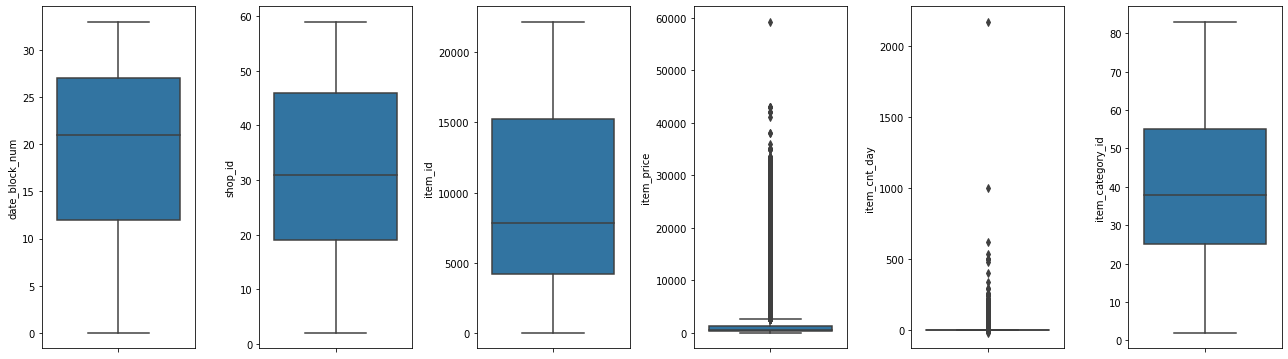

In [6]:
columns = [ 'date_block_num', 'shop_id', 'item_id',  'item_price', 'item_cnt_day', 'item_category_id']
no_of_col = len(columns)
plt.figure(figsize=(3*no_of_col, 10))
for cat in range(0, no_of_col):
  plt.subplot(2, no_of_col, cat+1)
  sns.boxplot(train[columns[cat]], orient='v')
  plt.tight_layout()

### We will remove outliers which are greater than 10000 in item price and greater than 1000 in items day count

In [7]:
train = train[(train['item_price']<100000) & (train['item_price']>=0)]
train = train[(train['item_cnt_day']<1000) & (train['item_cnt_day']>=0)]

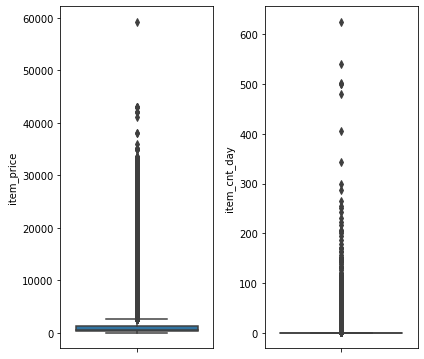

In [8]:
columns = ['item_price', 'item_cnt_day']

no_of_col = len(columns)
plt.figure(figsize=(3*no_of_col, 10))
for cat in range(0, no_of_col):
  plt.subplot(2, no_of_col, cat+1)
  sns.boxplot(train[columns[cat]], orient='v')
  plt.tight_layout()

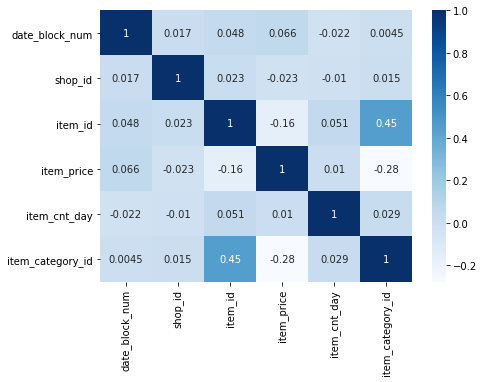

In [9]:
columns = [ 'date_block_num', 'shop_id', 'item_id',  'item_price', 'item_cnt_day', 'item_category_id']
corr = train[columns].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns, annot=True, cmap='Blues')

Above heatmap indicates that dark coloured boxes represent positively correlated lighter boxes represent negitively correlated

In [10]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

In [11]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

In [12]:
display(train.shape, test.shape)

(599911, 2)

(214200, 3)

### Describing the correlation between independent variables and independent variable

creating a list containing shop_id, item_id associated with each block from 0 - 33

Normalizing the numerical value to speed up training

In [13]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.to_numpy().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.to_numpy().reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.to_numpy().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.to_numpy().reshape(-1, 1))

In [14]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30      1              3         -0.071500      0.120290
                       4          0.042693      0.397127
                       5         -0.071500      0.212569
                       6          0.316249      2.334982
                       7          0.151161      0.673963
...                                    ...           ...
22167   33             28        -0.257099     -0.156546
                       37        -0.257099     -0.156546
                       42        -0.171526      0.120290
                       47        -0.257099     -0.156546
                       50        -0.257099     -0.156546

[599911 rows x 2 columns]

In [15]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [16]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [ ]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [ ]:
train_x = np.array(sentence[0])
val_x = np.array(sentence[1])
test_x = np.array(sentence[2])
train_y = np.array([row['item_cnt_day'] for row in next_chars[0]])
val_y = np.array([row['item_cnt_day'] for row in next_chars[1]])

length = len(test_shops) + len(test_items) + 7

In [ ]:
from sklearn import preprocessing

shop_lable = preprocessing.LabelEncoder()
shop_lable.fit(test_shops)
shop_dict = dict(zip(test_shops, shop_le.transform(test_shops)))

item_lable = preprocessing.LabelEncoder()
item_lable.fit(test_items)
item_dict = dict(zip(test_items, item_le.transform(test_items)))

month_lable = preprocessing.LabelEncoder()
month_lable.fit(range(7,11))
month_dict = dict(zip(range(7,11), month_le.transform(range(7,11))))

In [ ]:
x_train = np.vectorize(train_x)
x_test = np.vectorize(test_x)
x_val = np.vectorize(val_x)

In [ ]:
model = sequential()
model.add(LSTM(32, return_sequence=True, input_length=(4, length)))
model.add(LSTM(32, return_sequence=True))
model.add(Dense(10, activation='relu'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 20, batch_size = 4096)

In [ ]:
model.fit(x_val, y_val, batch_size=4096, epochs=20)